In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = yf.download("MSFT", start="2022-01-01", end="2025-01-01", actions=True, auto_adjust=False)
df.to_csv("MSFT")

[*********************100%***********************]  1 of 1 completed


In [3]:
x=pd.read_csv("MSFT.csv")
x.head()

,Date,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume
0,2022-01-03,324.504608,334.750000,0.0,338.000000,329.779999,335.350006,0.0,28865100
1,2022-01-04,318.940308,329.010010,0.0,335.200012,326.119995,334.829987,0.0,32674300
2,2022-01-05,306.696838,316.380005,0.0,326.070007,315.980011,325.859985,0.0,40054300
3,2022-01-06,304.273346,313.880005,0.0,318.700012,311.489990,313.149994,0.0,39646100
4,2022-01-07,304.428497,314.040009,0.0,316.500000,310.089996,314.149994,0.0,32720000


In [4]:
x.describe()

,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.0,7.530000e+02
mean,329.128733,334.534714,0.011169,337.775140,331.071407,334.538672,0.0,2.648493e+07
std,71.219312,70.181041,0.088183,70.170304,70.071156,70.222338,0.0,1.091602e+07
min,209.049637,214.250000,0.000000,220.410004,213.429993,217.550003,0.0,7.164500e+06
25%,265.244690,271.869995,0.000000,274.769989,267.869995,272.059998,0.0,1.940120e+07
50%,320.403015,326.049988,0.000000,329.200012,322.500000,325.660004,0.0,2.409330e+07
75%,405.817566,409.489990,0.000000,413.929993,406.369995,409.589996,0.0,3.039340e+07
max,463.240967,467.559998,0.830000,468.350006,464.459991,467.000000,0.0,9.042890e+07


In [5]:
daily_close = x ["Adj Close"]
daily_return = daily_close.pct_change()
daily_return.fillna(0,inplace=True)
print(daily_return)

0      0.000000
1     -0.017147
2     -0.038388
3     -0.007902
4      0.000510
         ...   
748    0.009374
749   -0.002777
750   -0.017302
751   -0.013240
752   -0.007838
Name: Adj Close, Length: 753, dtype: float64


In [6]:
short_mav = x["Adj Close"]. rolling (window=50).mean()
long_mav = x["Adj Close"]. rolling (window=120).mean()
print(short_mav[-10:])

743    422.742910
744    423.210509
745    423.616358
746    424.045813
747    424.438887
748    424.857134
749    425.259055
750    425.562215
751    425.740087
752    425.823137
Name: Adj Close, dtype: float64


<Axes: >

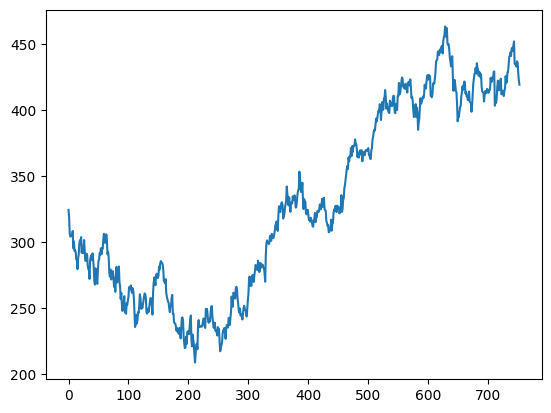

In [7]:
x["Adj Close"].plot()

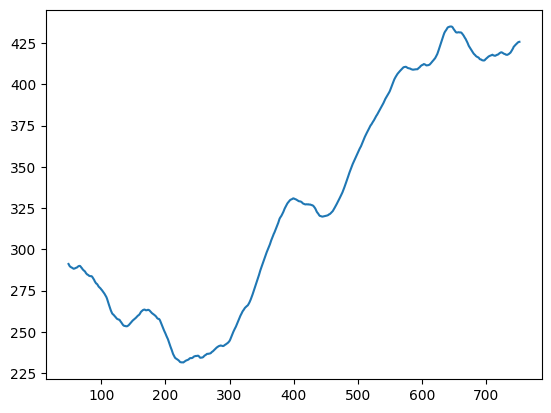

<Axes: >

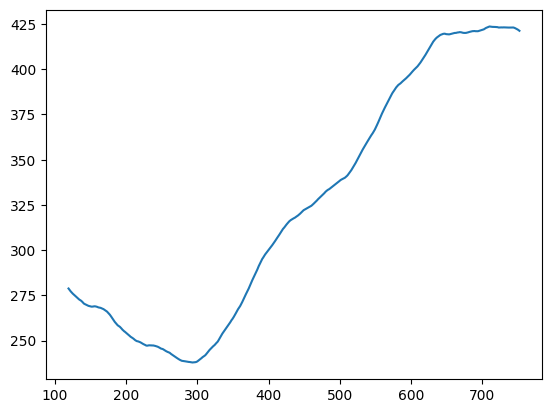

In [8]:
short_mav.plot()
plt.show()
long_mav.plot()

In [9]:
signal_df = pd.DataFrame(index=x.index)
signal_df ["signal"] = 0.0
signal_df ["short_mav"] = short_mav
signal_df['long_mav']=long_mav
signal_df.loc[50:, "signal"] = np.where(
    signal_df["short_mav"][50:] > signal_df["long_mav"][50:], 
    1.0, 
    0.0
)
signal_df['positions'] = signal_df['signal'].diff()
signal_df[signal_df['positions'] ==-1.0]


,signal,short_mav,long_mav,positions
444,0.0,319.888550,320.111354,-1.0
678,0.0,420.195309,420.198212,-1.0


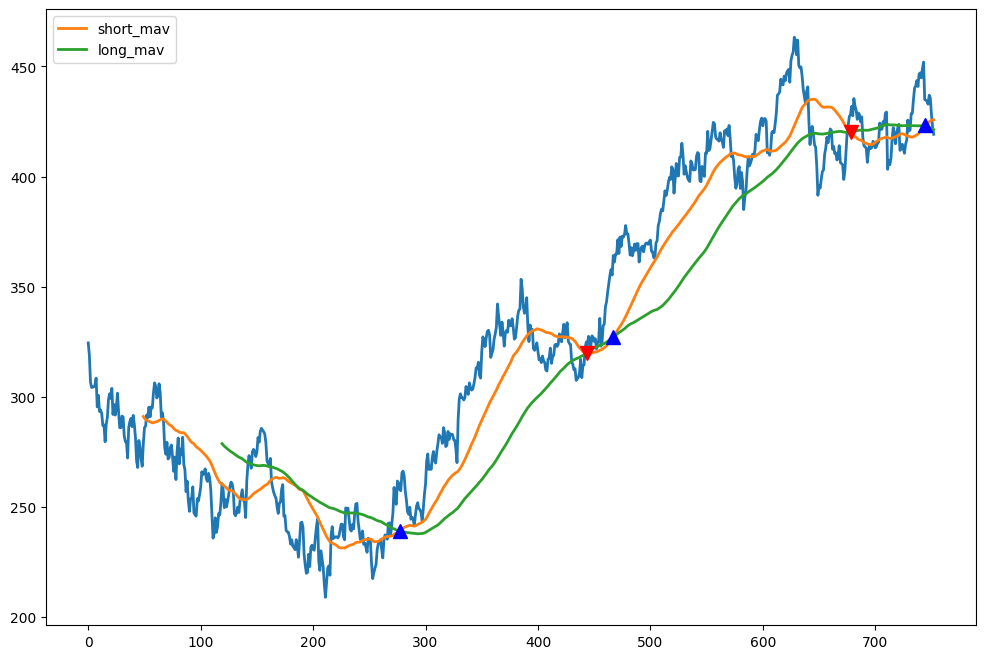

In [12]:
# initialize the plot using plt
fig = plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1)

x["Adj Close"].plot(ax=ax, lw=2)
signal_df[['short_mav', 'long_mav']].plot(ax=ax, lw=2., figsize=(12,8))
# plotting the sell signals
ax.plot(signal_df.loc[signal_df.positions ==-1.0].index,
 signal_df.short_mav[signal_df.positions ==-1.0],
 'v', markersize=10, color='r')
# plotting the Buy signals
ax.plot(signal_df.loc[signal_df.positions == 1.0].index,
 signal_df.short_mav[signal_df.positions == 1.0],
'^', markersize=10, color='b')

In [13]:
def apply_risk_management(signal_df, daily_return, stop_loss_pct=0.05, take_profit_pct=0.10):
  
    strategy_returns = pd.Series(0.0, index=daily_return.index)
    in_position = False
    entry_price = 0
    entry_index = None
    
    # Price data for stop loss calculations
    prices = x['Adj Close']
    
    for i in range(1, len(signal_df)):
        current_signal = signal_df['signal'].iloc[i]
        current_price = prices.iloc[i]
        prev_signal = signal_df['signal'].iloc[i-1]
        
        # ENTRY SIGNAL (Buy)
        if not in_position and current_signal == 1 and prev_signal == 0:
            in_position = True
            entry_price = current_price
            entry_index = i
            continue
        
        # EXIT CONDITIONS (if in position)
        if in_position:
            price_change_pct = (current_price - entry_price) / entry_price
            
            # STOP LOSS HIT
            if price_change_pct <= -stop_loss_pct:
                strategy_returns.iloc[i] = -stop_loss_pct  # Assume stop loss hit
                in_position = False
                entry_price = 0
                entry_index = None
            
            # TAKE PROFIT HIT
            elif price_change_pct >= take_profit_pct:
                strategy_returns.iloc[i] = take_profit_pct  # Assume take profit hit
                in_position = False
                entry_price = 0
                entry_index = None
            
            # NORMAL EXIT (MA crossover sell signal)
            elif current_signal == 0 and prev_signal == 1:
                actual_return = (current_price - entry_price) / entry_price
                strategy_returns.iloc[i] = actual_return
                in_position = False
                entry_price = 0
                entry_index = None
            
            # STILL IN POSITION - calculate intraday return
            else:
                strategy_returns.iloc[i] = daily_return.iloc[i]
        
        # NOT IN POSITION - no return
        else:
            strategy_returns.iloc[i] = 0.0
    
    return strategy_returns




In [14]:
def calculate_strategy_metrics_with_risk_management(x, signal_df, daily_return, 
                                                   stop_loss=0.05, take_profit=0.10, 
                                                   risk_free_rate=0.05):
    
    # Apply risk management
    strategy_returns = apply_risk_management(signal_df, daily_return, stop_loss, take_profit)
    
    # Remove NaN values
    strategy_returns = strategy_returns.dropna()
    daily_return_clean = daily_return.loc[strategy_returns.index]
    
    # Portfolio values (assuming initial investment of 10000)
    initial_investment = 15000
    strategy_portfolio = initial_investment * (1 + strategy_returns).cumprod()
    buy_hold_portfolio = initial_investment * (1 + daily_return_clean).cumprod()
    
    metrics = {}
    
    
    metrics['Strategy Total Return'] = (strategy_portfolio.iloc[-1] / strategy_portfolio.iloc[0]) - 1
    metrics['Buy & Hold Total Return'] = (buy_hold_portfolio.iloc[-1] / buy_hold_portfolio.iloc[0]) - 1
    
    excess_strategy_returns = strategy_returns - risk_free_rate/252
    excess_buy_hold_returns = daily_return_clean - risk_free_rate/252
    
    metrics['Strategy Sharpe Ratio'] = (excess_strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) 
                                        if strategy_returns.std() > 0 else 0)
    metrics['Buy & Hold Sharpe Ratio'] = (excess_buy_hold_returns.mean() / daily_return_clean.std() * np.sqrt(252) 
                                         if daily_return_clean.std() > 0 else 0)
    
    metrics['Strategy Portfolio Growth'] = strategy_portfolio.iloc[-1] - strategy_portfolio.iloc[0]
    metrics['Buy & Hold Portfolio Growth'] = buy_hold_portfolio.iloc[-1] - buy_hold_portfolio.iloc[0]
    
    metrics['Stop Loss Used'] = stop_loss
    metrics['Take Profit Used'] = take_profit
    metrics['Stop Loss Hits'] = len(strategy_returns[strategy_returns == -stop_loss])
    metrics['Take Profit Hits'] = len(strategy_returns[strategy_returns == take_profit])
    
    winning_trades = strategy_returns[strategy_returns != 0]
    if len(winning_trades) > 0:
        metrics['Win Rate'] = (winning_trades > 0).mean()
        metrics['Average Win'] = winning_trades[winning_trades > 0].mean()
        metrics['Average Loss'] = winning_trades[winning_trades < 0].mean()
        metrics['Profit Factor'] = abs(winning_trades[winning_trades > 0].sum() / 
                                      winning_trades[winning_trades < 0].sum())
    else:
        metrics['Win Rate'] = 0
        metrics['Average Win'] = 0
        metrics['Average Loss'] = 0
        metrics['Profit Factor'] = 0
    
    def calculate_max_drawdown(portfolio_values):
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values - peak) / peak
        return drawdown.min()
    
    metrics['Strategy Max Drawdown'] = calculate_max_drawdown(strategy_portfolio)
    metrics['Buy & Hold Max Drawdown'] = calculate_max_drawdown(buy_hold_portfolio)
    
    metrics['Strategy Volatility'] = strategy_returns.std() * np.sqrt(252)
    metrics['Buy & Hold Volatility'] = daily_return_clean.std() * np.sqrt(252)
    
    metrics['Number of Trades'] = len(signal_df[signal_df['positions'] != 0.0])
    metrics['Number of Buy Signals'] = len(signal_df[signal_df['positions'] == 1.0])
    metrics['Number of Sell Signals'] = len(signal_df[signal_df['positions'] == -1.0])
    
    return metrics, strategy_portfolio, buy_hold_portfolio, strategy_returns

In [19]:

# Test different stop loss and take profit levels
risk_params = [
    (0.03, 0.08),   # Tight stops
    (0.05, 0.10),   # Medium stops  
    (0.08, 0.15),   # Wide stops
    (0.10, 0.20),   # Very wide stops
    (0.12, 0.25)    
]

best_sharpe = -999
best_params = None
best_metrics = None

print("Testing different risk parameters...")

for stop_loss, take_profit in risk_params:
    try:
        metrics, strategy_portfolio, buy_hold_portfolio, strategy_returns = calculate_strategy_metrics_with_risk_management(
            x, signal_df, daily_return, stop_loss, take_profit
        )
        
        print(f"\nStop Loss: {stop_loss:.1%}, Take Profit: {take_profit:.1%}")
        print(f"Sharpe Ratio: {metrics['Strategy Sharpe Ratio']:.4f}")
        print(f"Total Return: {metrics['Strategy Total Return']:.2%}")
        print(f"Win Rate: {metrics['Win Rate']:.1%}")
        print(f"Stop Loss Hits: {metrics['Stop Loss Hits']}")
        print(f"Take Profit Hits: {metrics['Take Profit Hits']}")
        
        if metrics['Strategy Sharpe Ratio'] > best_sharpe:
            best_sharpe = metrics['Strategy Sharpe Ratio']
            best_params = (stop_loss, take_profit)
            best_metrics = metrics
            
    except Exception as e:
        print(f"Error with SL:{stop_loss}, TP:{take_profit}: {e}")


Testing different risk parameters...

Stop Loss: 3.0%, Take Profit: 8.0%
Sharpe Ratio: -0.5060
Total Return: 3.41%
Win Rate: 50.8%
Stop Loss Hits: 2
Take Profit Hits: 1

Stop Loss: 5.0%, Take Profit: 10.0%
Sharpe Ratio: -0.2950
Total Return: 6.83%
Win Rate: 51.4%
Stop Loss Hits: 1
Take Profit Hits: 1

Stop Loss: 8.0%, Take Profit: 15.0%
Sharpe Ratio: 0.7732
Total Return: 61.37%
Win Rate: 49.0%
Stop Loss Hits: 0
Take Profit Hits: 2

Stop Loss: 10.0%, Take Profit: 20.0%
Sharpe Ratio: 0.9920
Total Return: 99.26%
Win Rate: 51.1%
Stop Loss Hits: 0
Take Profit Hits: 2

Stop Loss: 12.0%, Take Profit: 25.0%
Sharpe Ratio: 1.0922
Total Return: 133.69%
Win Rate: 52.1%
Stop Loss Hits: 0
Take Profit Hits: 2


In [18]:
# FINAL RESULTS WITH BEST PARAMETERS
print("BEST RISK PARAMETERS FOUND")
print(f"Stop Loss: {best_params[0]:.1%}, Take Profit: {best_params[1]:.1%}")
print(f"Best Sharpe Ratio: {best_sharpe:.4f}")

# Run final analysis with best parameters
final_metrics, final_strategy_portfolio, final_buy_hold_portfolio, final_strategy_returns = calculate_strategy_metrics_with_risk_management(
    x, signal_df, daily_return, best_params[0], best_params[1]
)

print("\nFINAL STRATEGY PERFORMANCE WITH RISK MANAGEMENT")

print("\n--- RETURNS ---")
print(f"{'Strategy Total Return':30}: {final_metrics['Strategy Total Return']:>10.2%}")
print(f"{'Buy & Hold Total Return':30}: {final_metrics['Buy & Hold Total Return']:>10.2%}")

print("\n--- RISK METRICS ---")
print(f"{'Strategy Sharpe Ratio':30}: {final_metrics['Strategy Sharpe Ratio']:>10.3f}")
print(f"{'Strategy Max Drawdown':30}: {final_metrics['Strategy Max Drawdown']:>10.2%}")
print(f"{'Strategy Volatility':30}: {final_metrics['Strategy Volatility']:>10.2%}")

print("\n--- RISK MANAGEMENT STATS ---")
print(f"{'Stop Loss Hits':30}: {final_metrics['Stop Loss Hits']:>10}")
print(f"{'Take Profit Hits':30}: {final_metrics['Take Profit Hits']:>10}")
print(f"{'Win Rate':30}: {final_metrics['Win Rate']:>10.1%}")
print(f"{'Average Win':30}: {final_metrics['Average Win']:>10.2%}")
print(f"{'Average Loss':30}: {final_metrics['Average Loss']:>10.2%}")
print(f"{'Profit Factor':30}: {final_metrics['Profit Factor']:>10.2f}")


BEST RISK PARAMETERS FOUND
Stop Loss: 12.0%, Take Profit: 25.0%
Best Sharpe Ratio: 1.0922

FINAL STRATEGY PERFORMANCE WITH RISK MANAGEMENT

--- RETURNS ---
Strategy Total Return         :    133.69%
Buy & Hold Total Return       :     29.18%

--- RISK METRICS ---
Strategy Sharpe Ratio         :      1.092
Strategy Max Drawdown         :     -9.33%
Strategy Volatility           :     23.75%

--- RISK MANAGEMENT STATS ---
Stop Loss Hits                :          0
Take Profit Hits              :          2
Win Rate                      :      52.1%
Average Win                   :      1.53%
Average Loss                  :     -0.87%
Profit Factor                 :       1.92
